In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


In [3]:
# Load data
df = pd.read_csv('../data/linear_regression_data.csv')

# Remove `Scale Body Weight (kg)` column
df = df.drop(columns='Scale Body Weight (kg)')

# Convert `Date` column to date
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Calories (kcal),Moving Average Weight (kg),Cut or Bulk
0,2024-03-12,1870,84.50,Cut
1,2024-03-13,1730,84.50,Cut
2,2024-03-14,1926,84.50,Cut
3,2024-03-15,1738,84.50,Cut
4,2024-03-16,1800,84.50,Cut
...,...,...,...,...
437,2025-05-26,3012,75.64,Bulk
438,2025-05-27,3044,75.64,Bulk
439,2025-05-28,3097,75.54,Bulk
440,2025-05-29,3105,75.54,Bulk


In [6]:
# Summarise data by weeks - use mean calories for the week and latest moving average weight
df_weekly = df.groupby(pd.Grouper(key='Date', freq='W')).agg({
    'Calories (kcal)' : 'median', 
    'Moving Average Weight (kg)' : 'last',
    'Cut or Bulk' : lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}).reset_index()

# df_weekly = df.groupby(pd.Grouper(key='Date', freq='W')).agg({'Calories (kcal)' : 'mean', 'Moving Average Weight (kg)' : 'median'}).reset_index()
df_weekly

,Date,Calories (kcal),Moving Average Weight (kg),Cut or Bulk
0,2024-03-17,1817.0,84.50,Cut
1,2024-03-24,1836.0,84.19,Cut
2,2024-03-31,1828.0,83.92,Cut
3,2024-04-07,1844.0,83.73,Cut
4,2024-04-14,1679.0,83.01,Cut
...,...,...,...,...
59,2025-05-04,2923.0,75.53,Bulk
60,2025-05-11,2972.0,75.56,Bulk
61,2025-05-18,2950.0,75.77,Bulk
62,2025-05-25,3009.0,75.66,Bulk


In [7]:
# Add column for rate of weight change between end of weeks
df_weekly['weight_change_rate'] = df_weekly['Moving Average Weight (kg)'] - df_weekly['Moving Average Weight (kg)'].shift(1)

# Drop the row for the first week as it does not have a rate of weight change (no previous week)
df_weekly = df_weekly.dropna(subset='weight_change_rate').copy()
df_weekly

# Add column for number of days since minimum date
df_weekly['days_from_start'] = (df_weekly['Date'] - df_weekly['Date'].min()).dt.days

# Create binary column with Bulk:1 and Cut:0
df_weekly['Is Bulk'] = (df_weekly['Cut or Bulk'] == 'Bulk').astype(int)

df_weekly

,Date,Calories (kcal),Moving Average Weight (kg),Cut or Bulk,weight_change_rate,days_from_start,Is Bulk
1,2024-03-24,1836.0,84.19,Cut,-0.31,0,0
2,2024-03-31,1828.0,83.92,Cut,-0.27,7,0
3,2024-04-07,1844.0,83.73,Cut,-0.19,14,0
4,2024-04-14,1679.0,83.01,Cut,-0.72,21,0
5,2024-04-21,1744.0,82.31,Cut,-0.70,28,0
...,...,...,...,...,...,...,...
59,2025-05-04,2923.0,75.53,Bulk,0.04,406,1
60,2025-05-11,2972.0,75.56,Bulk,0.03,413,1
61,2025-05-18,2950.0,75.77,Bulk,0.21,420,1
62,2025-05-25,3009.0,75.66,Bulk,-0.11,427,1


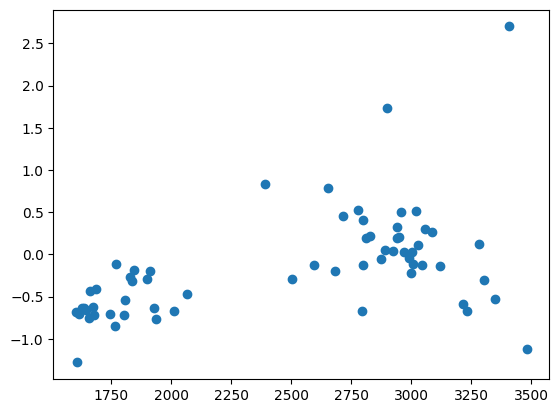

In [8]:
# Plotting weight change against average calories
plt.scatter(x=df_weekly['Calories (kcal)'], y=df_weekly['weight_change_rate'])
plt.show()

<Axes: >

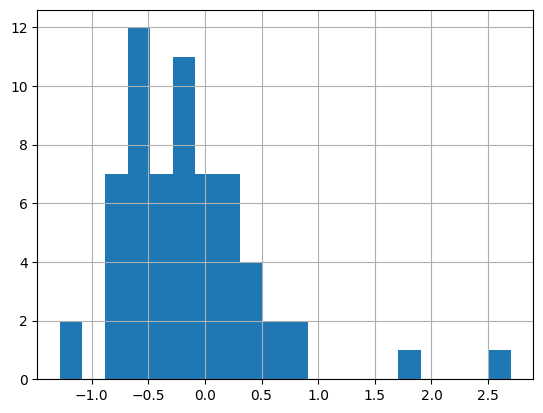

In [9]:
df_weekly['weight_change_rate'].hist(bins=20)

In [10]:
# Cleaning data - remove outliers
Q1 = df_weekly['weight_change_rate'].quantile(0.25)
Q3 = df_weekly['weight_change_rate'].quantile(0.75)
IQR = Q3-Q1

# Use conservative multiplier of 0.8 as some weight changes are due to measurement errors due 
# to use different body weight scales
lower_limit = Q1 - (0.6 * IQR)
upper_limit = Q3 + (0.6 * IQR)

print(lower_limit)
print(upper_limit)

weight_change_outliers = df_weekly[(df_weekly['weight_change_rate'] < lower_limit) | (df_weekly['weight_change_rate'] > upper_limit)]
weight_change_outliers

print(weight_change_outliers.index)

df_weekly_cleaned = df_weekly[~df_weekly.index.isin(weight_change_outliers.index)]
df_weekly_cleaned

-1.100999999999989
0.6259999999999877
Index([11, 12, 16, 50, 51, 54], dtype='int64')


,Date,Calories (kcal),Moving Average Weight (kg),Cut or Bulk,weight_change_rate,days_from_start,Is Bulk
1,2024-03-24,1836.0,84.19,Cut,-0.31,0,0
2,2024-03-31,1828.0,83.92,Cut,-0.27,7,0
3,2024-04-07,1844.0,83.73,Cut,-0.19,14,0
4,2024-04-14,1679.0,83.01,Cut,-0.72,21,0
5,2024-04-21,1744.0,82.31,Cut,-0.70,28,0
6,2024-04-28,1635.0,81.68,Cut,-0.63,35,0
7,2024-05-05,1768.0,80.83,Cut,-0.85,42,0
8,2024-05-12,2010.0,80.16,Cut,-0.67,49,0
9,2024-05-19,2596.0,80.04,Bulk,-0.12,56,1
10,2024-05-26,2715.0,80.50,Bulk,0.46,63,1


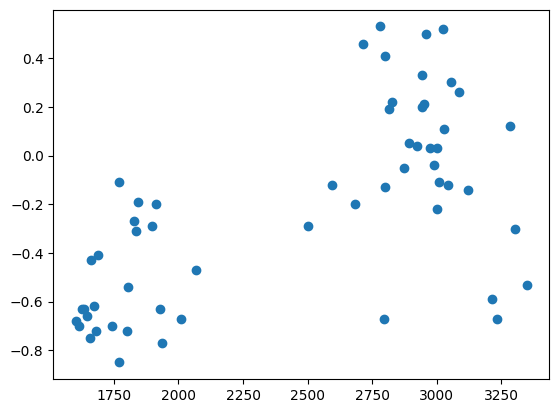

In [11]:
# Plotting weight change against average calories for cleaned data
plt.scatter(x=df_weekly_cleaned['Calories (kcal)'], y=df_weekly_cleaned['weight_change_rate'])
plt.show()

In [12]:
# Select features (X) and target (y)
X = df_weekly_cleaned[['Calories (kcal)', 'Moving Average Weight (kg)', 'days_from_start', 'Is Bulk']]
y = df_weekly_cleaned['weight_change_rate']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardise features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train linear model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.0528
R² Score: 0.5938


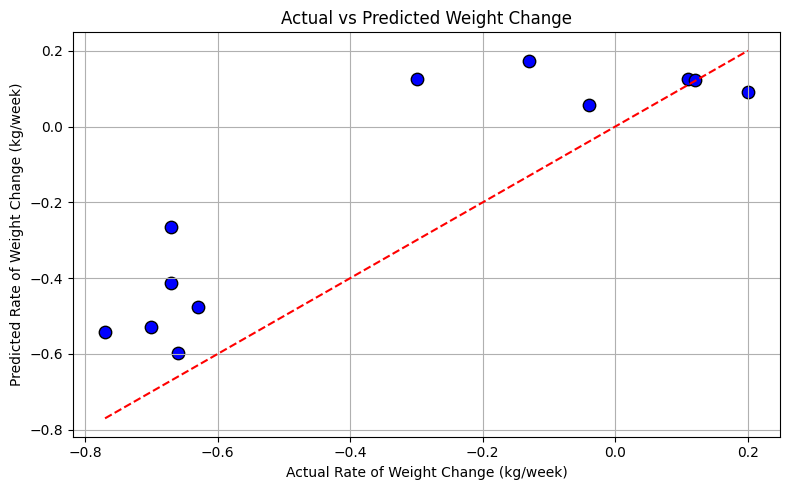

In [13]:
# Plotting actual weight change vs predicted weight change
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', s=80)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Rate of Weight Change (kg/week)")
plt.ylabel("Predicted Rate of Weight Change (kg/week)")
plt.title("Actual vs Predicted Weight Change")
plt.grid(True)
plt.tight_layout()
plt.show()


# Creating Decision Tree

Mean Squared Error: 0.1026
R² Score: -0.0145


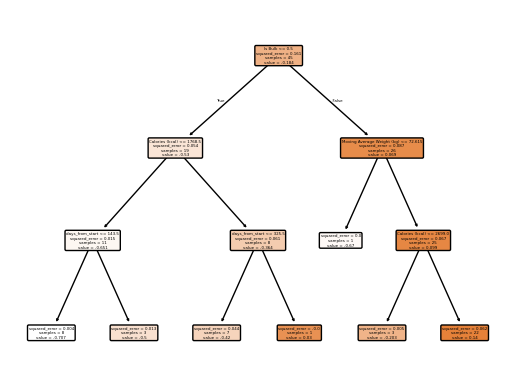

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# Select features (X) and target (y)
X = df_weekly_cleaned[['Calories (kcal)', 'Moving Average Weight (kg)', 'days_from_start', 'Is Bulk']]
y = df_weekly_cleaned['weight_change_rate']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialise and train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(max_depth=3)
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

plot_tree(dt_model, feature_names=X.columns, filled=True, rounded=True)
plt.show()

# Creating Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Select features (X) and target (y)
X = df_weekly_cleaned[['Calories (kcal)', 'Moving Average Weight (kg)', 'days_from_start', 'Is Bulk']]
y = df_weekly_cleaned['weight_change_rate']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create random forest regressor
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=3,
    min_samples_leaf=1,
    min_samples_split = 3,
    random_state=42
)

# Fit model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.0401
R² Score: 0.5856


In [16]:
# Tuning hyperparameters of Random Forest Regressor using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300],           # Number of trees
    'max_depth': [2, 3, 4],           # Max depth of each tree
    'min_samples_split': [2, 4, 8, 15, 20],          # Min samples required to split a node
    'min_samples_leaf': [1],            # Min samples required at a leaf node
    'max_features': ['log2', 0.8]         # Number of features to consider when looking for the best split
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best R² score on training data:", grid_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 300}
Best R² score on training data: 0.1815641451652166


In [104]:
from datetime import datetime

# Getting best model from GridSearchCV
rf_best_model = grid_search.best_estimator_

# Input data to make prediction with
current_date = datetime.now().date()
current_days_from_start = (current_date - df_weekly_cleaned['Date'].dt.date.min()).days
new_data = pd.DataFrame({
    'Calories (kcal)': [3100],
    'Moving Average Weight (kg)': 75.6,
    'days_from_start': current_days_from_start,
    'Is Bulk': 1
})

# Make predictions
prediction = rf_best_model.predict(new_data)
prediction
print(f'Predicted weight change: {prediction[0]:.3f}')

Predicted weight change: -0.029


In [18]:
# Tuning hyperparameters of Random Forest Regressor using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the parameter distributions
param_distributions = {
    'n_estimators': [300],  # or use randint(100, 500) if you want a range
    'max_depth': randint(2, 10),  # or use randint(2, 10)
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 0.8],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of random combinations to try
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best R² score on training data:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 300}
Best R² score on training data: 0.018344384639101596


# Creating Ridge Regressor

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define a range of alpha values (regularization strength)
param_grid = {'alpha': np.logspace(-4, 4, 20)}

ridge = Ridge()

# Use GridSearchCV to find the best alpha
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_['alpha'])
print("Best R² score (cross-validated):", grid_search.best_score_)

# Use the best model from the grid search
best_ridge = grid_search.best_estimator_

y_pred = best_ridge.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best alpha: 4.281332398719396
Best R² score (cross-validated): -0.05823848217066561
Test R²: 0.43306239534380675


# Create K-Nearest Neighbours Model

In [132]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Select features (X) and target (y)
X = df_weekly_cleaned[['Calories (kcal)', 'Moving Average Weight (kg)', 'days_from_start', 'Is Bulk']]
y = df_weekly_cleaned['weight_change_rate']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = knn.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f'R2 score: {r2:.4f}')


R2 score: 0.6896


In [146]:
# Perform hyperparameter tuning on KNN model
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 4, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean distance
}

grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best R² score on training data:", grid_search.best_score_)

# Get best model
best_knn = grid_search.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best parameters found: {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
Best R² score on training data: 0.18890792854890753
